In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to your CSV file
CSV_PATH = "../data/polymarket-price-data-24-07-2025-24-10-2025-1761316761596.csv" # change if your filename is different

OUTCOME_COLS = ["50+ bps decrease", "25 bps decrease", "No change", "25+ bps increase"]


In [10]:
# Read CSV (handles quoted headers as in your sample)
df = pd.read_csv(CSV_PATH)

# Normalize column names
df.columns = [c.strip() for c in df.columns]

# Basic sanity check
expected = {"Date (UTC)", "Timestamp (UTC)", *OUTCOME_COLS}
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# Ensure numeric timestamp (seconds). Drop any rows where it can't be parsed.
df["Timestamp (UTC)"] = pd.to_numeric(df["Timestamp (UTC)"], errors="coerce")
df = df.dropna(subset=["Timestamp (UTC)"]).copy()
df["Timestamp (UTC)"] = df["Timestamp (UTC)"].astype("int64")

# Outcomes to float; empty strings → NaN
for col in OUTCOME_COLS:
    df[col] = pd.to_numeric(df[col], errors="coerce")


In [11]:
# Collapse to one row per timestamp.
# Strategy: take the *last* non-NaN per outcome at each timestamp.
# (You can switch to "max" if you prefer.)
agg_dict = {col: "last" for col in OUTCOME_COLS}

df_agg = (
    df.sort_values("Timestamp (UTC)")
      .groupby("Timestamp (UTC)", as_index=True)
      .agg(agg_dict)
      .sort_index()
      .reset_index()
)

# Build UTC datetime index
df_agg["ts"] = pd.to_datetime(df_agg["Timestamp (UTC)"], unit="s", utc=True)
df_agg = df_agg.set_index("ts").drop(columns=["Timestamp (UTC)"]).sort_index()

# Optional: forward-fill to smooth sparse updates
df_agg = df_agg.ffill()

df_agg.tail(3)


,50+ bps decrease,25 bps decrease,No change,25+ bps increase
ts,,,,
2025-10-24 14:39:05+00:00,0.014,0.9715,0.0225,0.0015
2025-10-24 14:39:06+00:00,0.014,0.9715,0.0120,0.0015
2025-10-24 14:39:07+00:00,0.014,0.9715,0.0120,0.0015


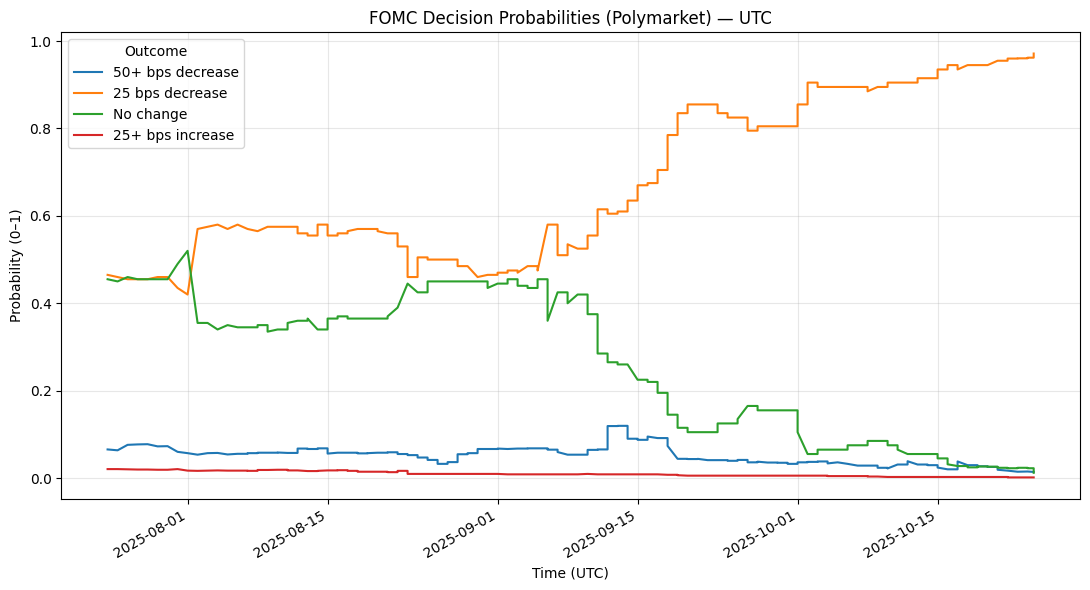

In [12]:
ax = df_agg.plot(figsize=(11, 6), title="FOMC Decision Probabilities (Polymarket) — UTC")
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Probability (0–1)")
ax.legend(title="Outcome", loc="best")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Constructing data frame


In [15]:
# Data Merging: S&P 500 Returns + Polymarket Quotes (Properly Cleaned)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print("🔄 Loading datasets...")

# Load S&P 500 data
sp500_path = "../data/sp500_ohlcv_returns.csv"
sp500_df = pd.read_csv(sp500_path, index_col=0, parse_dates=True)
print(f"📈 S&P 500 data: {sp500_df.shape} records")

# Load Polymarket data
polymarket_path = "../data/polymarket-price-data-24-07-2025-24-10-2025-1761316761596.csv"
polymarket_raw = pd.read_csv(polymarket_path)
print(f"🎯 Raw Polymarket data: {polymarket_raw.shape} records")

# 🔧 PROPER CLEANING: Handle multiple entries per day
print("\n🔧 Properly cleaning Polymarket data...")

# Convert date column
polymarket_raw['Date (UTC)'] = pd.to_datetime(polymarket_raw['Date (UTC)'])

# Convert empty strings to NaN
prob_columns = ["50+ bps decrease", "25 bps decrease", "No change", "25+ bps increase"]
for col in prob_columns:
    polymarket_raw[col] = polymarket_raw[col].replace('', np.nan)
    polymarket_raw[col] = pd.to_numeric(polymarket_raw[col], errors='coerce')

# 🔑 KEY INSIGHT: Each row represents a different outcome, not separate observations
# We need to pivot/reshape the data to get one row per date with all probabilities

print("📊 Analyzing data structure...")
print(f"Unique dates: {polymarket_raw['Date (UTC)'].nunique()}")
print(f"Total rows: {len(polymarket_raw)}")
print(f"Average rows per date: {len(polymarket_raw) / polymarket_raw['Date (UTC)'].nunique():.1f}")

# Method 1: Group by date and take the LAST non-null value for each outcome
print("\n🔧 Method 1: Taking last non-null values per date...")

polymarket_cleaned = polymarket_raw.groupby('Date (UTC)').agg({
    '50+ bps decrease': lambda x: x.dropna().iloc[-1] if len(x.dropna()) > 0 else np.nan,
    '25 bps decrease': lambda x: x.dropna().iloc[-1] if len(x.dropna()) > 0 else np.nan,
    'No change': lambda x: x.dropna().iloc[-1] if len(x.dropna()) > 0 else np.nan,
    '25+ bps increase': lambda x: x.dropna().iloc[-1] if len(x.dropna()) > 0 else np.nan
}).reset_index()

# Set date as index
polymarket_df = polymarket_cleaned.set_index('Date (UTC)')

# Check probability sums
print("\n📊 Checking probability sums...")
prob_sums = (polymarket_df['50+ bps decrease'] + 
             polymarket_df['25 bps decrease'] + 
             polymarket_df['No change'] + 
             polymarket_df['25+ bps increase'])

print(f"Probability sums - Min: {prob_sums.min():.4f}, Max: {prob_sums.max():.4f}, Mean: {prob_sums.mean():.4f}")

# Identify arbitrage opportunities (sums != 1)
arbitrage_days = abs(prob_sums - 1) > 0.01  # More than 1% deviation
print(f"Days with potential arbitrage (sum ≠ 1): {arbitrage_days.sum()}")

if arbitrage_days.sum() > 0:
    print("📈 Arbitrage opportunities found:")
    arbitrage_data = polymarket_df[arbitrage_days]
    for idx, row in arbitrage_data.iterrows():
        total = row['50+ bps decrease'] + row['25 bps decrease'] + row['No change'] + row['25+ bps increase']
        print(f"  {idx.date()}: Sum = {total:.4f}")

# Normalize probabilities to sum to 1 (remove arbitrage)
print("\n🔧 Normalizing probabilities to sum to 1...")
for col in prob_columns:
    polymarket_df[f'{col}_normalized'] = polymarket_df[col] / prob_sums

# Use normalized probabilities
polymarket_df['50+ bps decrease'] = polymarket_df['50+ bps decrease_normalized']
polymarket_df['25 bps decrease'] = polymarket_df['25 bps decrease_normalized']
polymarket_df['No change'] = polymarket_df['No change_normalized']
polymarket_df['25+ bps increase'] = polymarket_df['25+ bps increase_normalized']

# Drop normalized columns
polymarket_df = polymarket_df.drop(columns=[f'{col}_normalized' for col in prob_columns])

# Verify normalization
prob_sums_normalized = (polymarket_df['50+ bps decrease'] + 
                       polymarket_df['25 bps decrease'] + 
                       polymarket_df['No change'] + 
                       polymarket_df['25+ bps increase'])
print(f"After normalization - All sums = 1: {np.allclose(prob_sums_normalized, 1)}")

# Create derived features
polymarket_df['Rate_Cut_Probability'] = polymarket_df['50+ bps decrease'] + polymarket_df['25 bps decrease']
polymarket_df['Rate_Hike_Probability'] = polymarket_df['25+ bps increase']
polymarket_df['No_Change_Probability'] = polymarket_df['No change']

# Calculate market uncertainty (entropy)
polymarket_df['Uncertainty'] = -(
    polymarket_df['Rate_Cut_Probability'] * np.log(polymarket_df['Rate_Cut_Probability'] + 1e-10) +
    polymarket_df['No_Change_Probability'] * np.log(polymarket_df['No_Change_Probability'] + 1e-10) +
    polymarket_df['Rate_Hike_Probability'] * np.log(polymarket_df['Rate_Hike_Probability'] + 1e-10)
)

print(f"📅 Cleaned Polymarket date range: {polymarket_df.index.min()} to {polymarket_df.index.max()}")
print(f"📊 Final Polymarket shape: {polymarket_df.shape}")

# Filter S&P 500 data to start from Polymarket start date
polymarket_start_date = polymarket_df.index.min()
print(f"\n📅 Filtering S&P 500 data to start from: {polymarket_start_date}")

sp500_filtered = sp500_df[sp500_df.index >= polymarket_start_date].copy()
print(f"📈 Filtered S&P 500 data: {sp500_filtered.shape} records")

# Merge datasets
print("\n🔗 Merging datasets...")
merged_df = pd.merge(
    sp500_filtered, 
    polymarket_df, 
    left_index=True, 
    right_index=True, 
    how='inner'
)

print(f"✅ Merged dataset: {merged_df.shape} records")
print(f"📅 Merged date range: {merged_df.index.min()} to {merged_df.index.max()}")

# Show sample of cleaned data
print("\n📋 Sample of cleaned merged data:")
sample_cols = ['Close', 'Daily_Return', 'Rate_Cut_Probability', 'No_Change_Probability', 'Uncertainty']
print(merged_df[sample_cols].head(10))

# Verify probability sums in final data
final_prob_sums = (merged_df['50+ bps decrease'] + 
                   merged_df['25 bps decrease'] + 
                   merged_df['No change'] + 
                   merged_df['25+ bps increase'])
print(f"\n✅ Final probability sums - All equal to 1: {np.allclose(final_prob_sums, 1)}")

# Basic statistics
print("\n📈 Key Statistics:")
print(f"Average S&P 500 daily return: {merged_df['Daily_Return'].mean():.4f}")
print(f"S&P 500 volatility: {merged_df['Daily_Return'].std():.4f}")
print(f"Average rate cut probability: {merged_df['Rate_Cut_Probability'].mean():.4f}")
print(f"Average uncertainty: {merged_df['Uncertainty'].mean():.4f}")

# Save cleaned dataset
output_path = "../data/merged_sp500_polymarket_properly_cleaned.csv"
merged_df.to_csv(output_path)
print(f"\n💾 Saved properly cleaned dataset to: {output_path}")

print("\n✅ Data properly cleaned - one entry per day, probabilities sum to 1!")

🔄 Loading datasets...
📈 S&P 500 data: (656, 14) records
🎯 Raw Polymarket data: (297, 6) records

🔧 Properly cleaning Polymarket data...
📊 Analyzing data structure...
Unique dates: 94
Total rows: 297
Average rows per date: 3.2

🔧 Method 1: Taking last non-null values per date...

📊 Checking probability sums...
Probability sums - Min: 0.9670, Max: 1.0140, Mean: 1.0000
Days with potential arbitrage (sum ≠ 1): 12
📈 Arbitrage opportunities found:
  2025-07-26: Sum = 1.0110
  2025-08-01: Sum = 1.0140
  2025-08-07: Sum = 0.9885
  2025-08-09: Sum = 0.9865
  2025-08-23: Sum = 0.9670
  2025-08-24: Sum = 0.9865
  2025-08-30: Sum = 0.9860
  2025-08-31: Sum = 0.9760
  2025-09-03: Sum = 0.9860
  2025-09-06: Sum = 1.0135
  2025-09-11: Sum = 0.9740
  2025-09-18: Sum = 1.0110

🔧 Normalizing probabilities to sum to 1...
After normalization - All sums = 1: True
📅 Cleaned Polymarket date range: 2025-07-24 00:00:00 to 2025-10-24 14:39:00
📊 Final Polymarket shape: (94, 8)

📅 Filtering S&P 500 data to start 

📈 S&P 500 Returns Visualization
📊 Loaded data: (65, 22) records
📅 Date range: 2025-07-24 00:00:00 to 2025-10-23 00:00:00


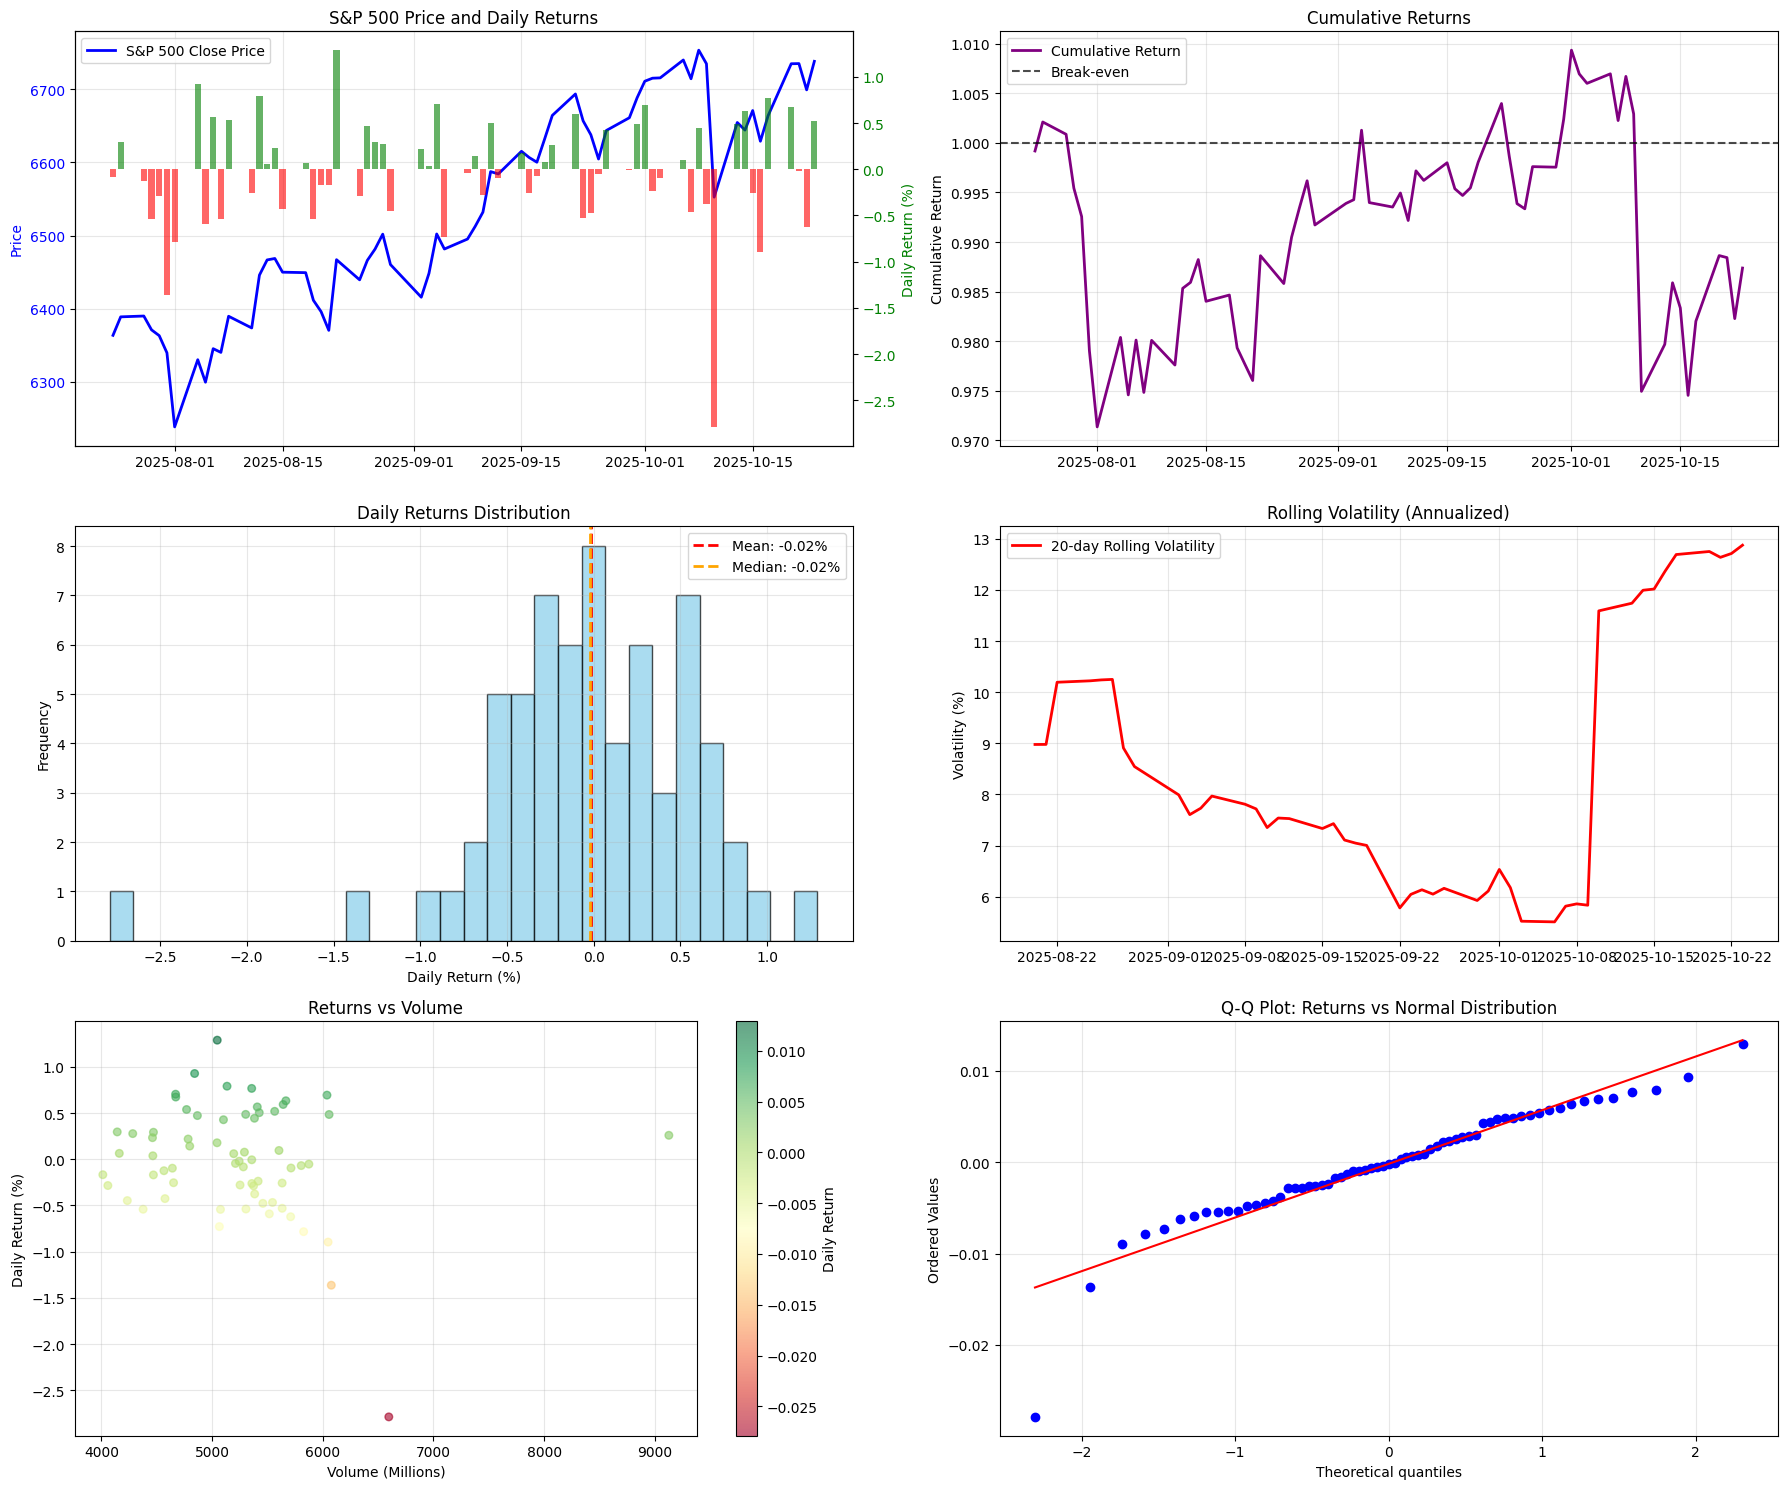


📊 S&P 500 Returns Statistical Summary
Basic Statistics:
  Mean daily return: -0.000177 (-0.0177%)
  Median daily return: -0.000208 (-0.0208%)
  Standard deviation: 0.006081 (0.6081%)
  Skewness: -1.4075
  Kurtosis: 5.6987

Annualized Metrics:
  Annual return: -0.0446 (-4.46%)
  Annual volatility: 0.0965 (9.65%)
  Sharpe ratio: -0.4625

Risk Metrics:
  Best single day: 0.0129 (1.29%)
  Worst single day: -0.0279 (-2.79%)
  Range: 0.0408 (4.08%)

Drawdown Analysis:
  Maximum drawdown: -0.0345 (-3.45%)
  Current drawdown: -0.0218 (-2.18%)

Monthly Performance:
           mean       std  count
Month                           
7     -0.003512  0.005663      6
8      0.000628  0.005594     21
9      0.000516  0.003772     21
10    -0.000851  0.008651     17

📈 Creating additional visualizations...


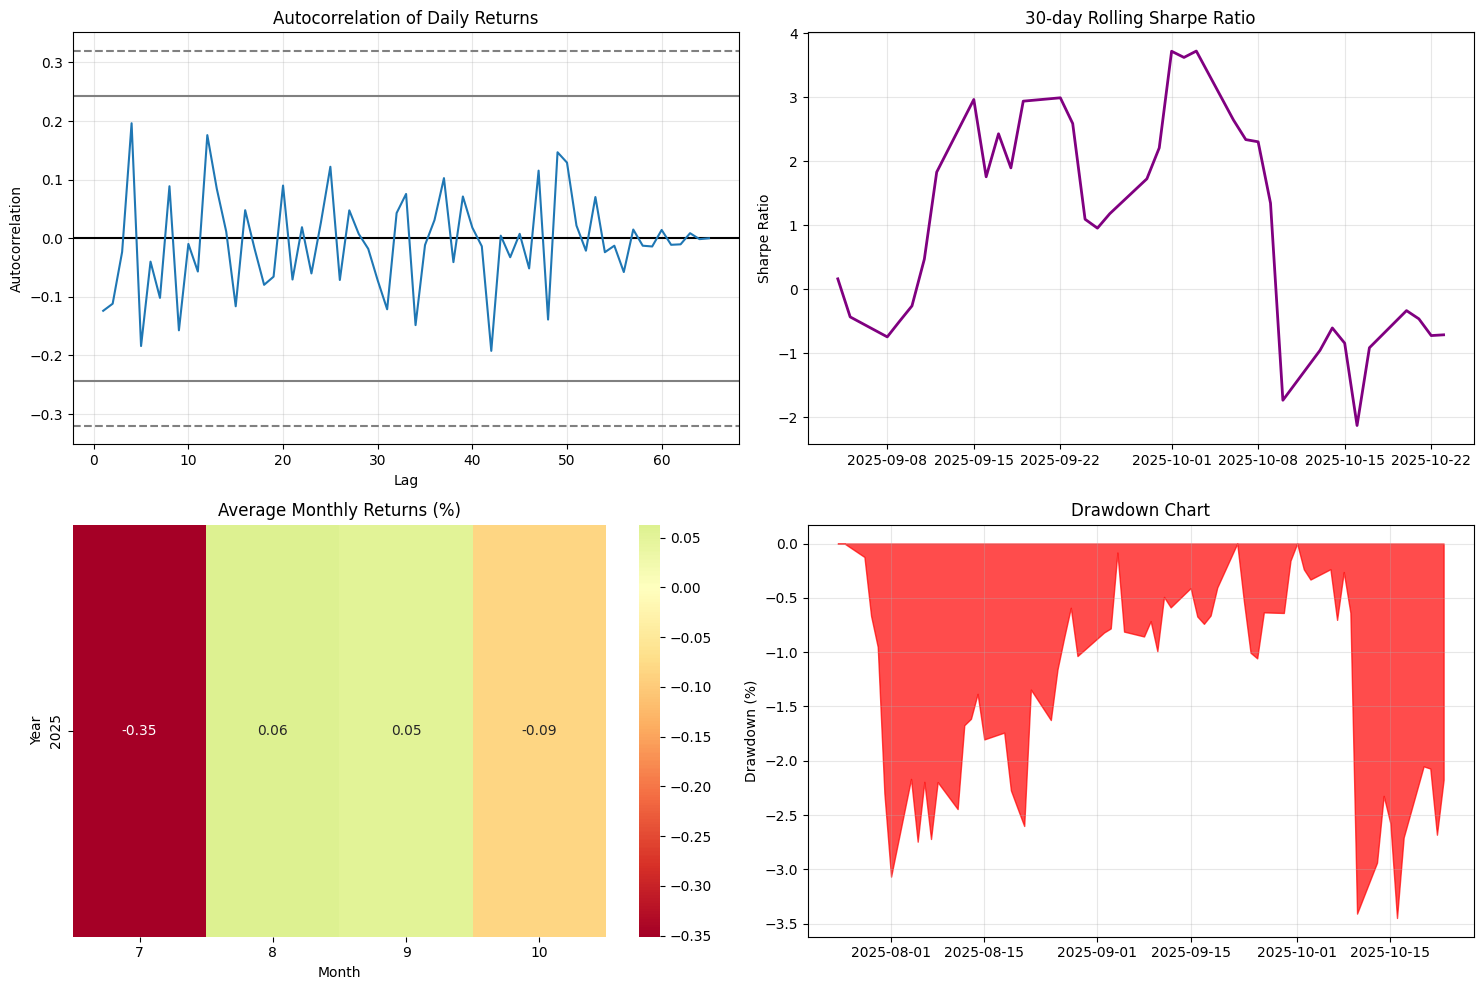


📊 Final Summary
Total trading days: 65
Total return: -1.26%
Average daily return: -0.0177%
Daily volatility: 0.6081%
Sharpe ratio: -0.4625
Maximum drawdown: -3.45%

✅ S&P 500 returns analysis complete!


In [20]:
# S&P 500 Returns Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print("📈 S&P 500 Returns Visualization")
print("=" * 40)

# Load the data
data_path = "../data/merged_sp500_polymarket_properly_cleaned.csv"
df = pd.read_csv(data_path, index_col=0, parse_dates=True)

print(f"📊 Loaded data: {df.shape} records")
print(f"📅 Date range: {df.index.min()} to {df.index.max()}")

# Calculate additional return metrics
df['Daily_Return'] = (df['Close'] - df['Open']) / df['Open']
df['Log_Return'] = np.log(df['Close'] / df['Open'])
df['Cumulative_Return'] = (1 + df['Daily_Return']).cumprod()
df['Rolling_Volatility'] = df['Daily_Return'].rolling(20).std() * np.sqrt(252)

# 📊 COMPREHENSIVE S&P 500 RETURNS VISUALIZATION
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

# Plot 1: S&P 500 Price and Daily Returns
ax1 = axes[0, 0]
ax1_twin = ax1.twinx()

# Price line
ax1.plot(df.index, df['Close'], 'b-', linewidth=2, label='S&P 500 Close Price')
ax1.set_ylabel('Price', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Daily returns bars
colors = ['green' if x > 0 else 'red' for x in df['Daily_Return']]
ax1_twin.bar(df.index, df['Daily_Return'] * 100, alpha=0.6, color=colors, width=0.8)
ax1_twin.set_ylabel('Daily Return (%)', color='g')
ax1_twin.tick_params(axis='y', labelcolor='g')

ax1.set_title('S&P 500 Price and Daily Returns')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative Returns
ax2 = axes[0, 1]
ax2.plot(df.index, df['Cumulative_Return'], 'purple', linewidth=2, label='Cumulative Return')
ax2.axhline(y=1, color='black', linestyle='--', alpha=0.7, label='Break-even')
ax2.set_title('Cumulative Returns')
ax2.set_ylabel('Cumulative Return')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Return Distribution
ax3 = axes[1, 0]
ax3.hist(df['Daily_Return'] * 100, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax3.axvline(df['Daily_Return'].mean() * 100, color='red', linestyle='--', linewidth=2, label=f'Mean: {df["Daily_Return"].mean()*100:.2f}%')
ax3.axvline(df['Daily_Return'].median() * 100, color='orange', linestyle='--', linewidth=2, label=f'Median: {df["Daily_Return"].median()*100:.2f}%')
ax3.set_title('Daily Returns Distribution')
ax3.set_xlabel('Daily Return (%)')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Rolling Volatility
ax4 = axes[1, 1]
ax4.plot(df.index, df['Rolling_Volatility'] * 100, 'red', linewidth=2, label='20-day Rolling Volatility')
ax4.set_title('Rolling Volatility (Annualized)')
ax4.set_ylabel('Volatility (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Returns vs Volume
ax5 = axes[2, 0]
scatter = ax5.scatter(df['Volume'] / 1e6, df['Daily_Return'] * 100, 
                     c=df['Daily_Return'], cmap='RdYlGn', alpha=0.6, s=30)
ax5.set_xlabel('Volume (Millions)')
ax5.set_ylabel('Daily Return (%)')
ax5.set_title('Returns vs Volume')
ax5.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax5, label='Daily Return')

# Plot 6: Q-Q Plot for Normality
ax6 = axes[2, 1]
from scipy import stats
stats.probplot(df['Daily_Return'], dist="norm", plot=ax6)
ax6.set_title('Q-Q Plot: Returns vs Normal Distribution')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 📊 STATISTICAL SUMMARY
print("\n📊 S&P 500 Returns Statistical Summary")
print("=" * 50)

# Basic statistics
returns = df['Daily_Return']
print(f"Basic Statistics:")
print(f"  Mean daily return: {returns.mean():.6f} ({returns.mean()*100:.4f}%)")
print(f"  Median daily return: {returns.median():.6f} ({returns.median()*100:.4f}%)")
print(f"  Standard deviation: {returns.std():.6f} ({returns.std()*100:.4f}%)")
print(f"  Skewness: {returns.skew():.4f}")
print(f"  Kurtosis: {returns.kurtosis():.4f}")

# Annualized metrics
annual_return = returns.mean() * 252
annual_vol = returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_vol

print(f"\nAnnualized Metrics:")
print(f"  Annual return: {annual_return:.4f} ({annual_return*100:.2f}%)")
print(f"  Annual volatility: {annual_vol:.4f} ({annual_vol*100:.2f}%)")
print(f"  Sharpe ratio: {sharpe_ratio:.4f}")

# Risk metrics
max_return = returns.max()
min_return = returns.min()
worst_5_days = returns.nsmallest(5)
best_5_days = returns.nlargest(5)

print(f"\nRisk Metrics:")
print(f"  Best single day: {max_return:.4f} ({max_return*100:.2f}%)")
print(f"  Worst single day: {min_return:.4f} ({min_return*100:.2f}%)")
print(f"  Range: {max_return - min_return:.4f} ({(max_return - min_return)*100:.2f}%)")

# Drawdown analysis
cumulative = (1 + returns).cumprod()
running_max = cumulative.cummax()
drawdown = (cumulative - running_max) / running_max
max_drawdown = drawdown.min()

print(f"\nDrawdown Analysis:")
print(f"  Maximum drawdown: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")
print(f"  Current drawdown: {drawdown.iloc[-1]:.4f} ({drawdown.iloc[-1]*100:.2f}%)")

# Performance by month
df['Month'] = df.index.month
monthly_returns = df.groupby('Month')['Daily_Return'].agg(['mean', 'std', 'count'])
print(f"\nMonthly Performance:")
print(monthly_returns.round(6))

# 📈 ADDITIONAL VISUALIZATIONS
print("\n📈 Creating additional visualizations...")

# Create a second figure for more detailed analysis
fig2, axes2 = plt.subplots(2, 2, figsize=(15, 10))

# Plot 7: Autocorrelation of returns
ax7 = axes2[0, 0]
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(returns, ax=ax7)
ax7.set_title('Autocorrelation of Daily Returns')
ax7.grid(True, alpha=0.3)

# Plot 8: Rolling Sharpe Ratio
ax8 = axes2[0, 1]
rolling_sharpe = returns.rolling(30).mean() / returns.rolling(30).std() * np.sqrt(252)
ax8.plot(df.index, rolling_sharpe, 'purple', linewidth=2)
ax8.set_title('30-day Rolling Sharpe Ratio')
ax8.set_ylabel('Sharpe Ratio')
ax8.grid(True, alpha=0.3)

# Plot 9: Returns over time (heatmap style)
ax9 = axes2[1, 0]
# Create a pivot table for heatmap
df['Year'] = df.index.year
df['Month'] = df.index.month
monthly_pivot = df.pivot_table(values='Daily_Return', index='Year', columns='Month', aggfunc='mean')
sns.heatmap(monthly_pivot * 100, annot=True, fmt='.2f', cmap='RdYlGn', center=0, ax=ax9)
ax9.set_title('Average Monthly Returns (%)')
ax9.set_xlabel('Month')
ax9.set_ylabel('Year')

# Plot 10: Drawdown chart
ax10 = axes2[1, 1]
ax10.fill_between(df.index, drawdown * 100, 0, alpha=0.7, color='red')
ax10.set_title('Drawdown Chart')
ax10.set_ylabel('Drawdown (%)')
ax10.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 📊 FINAL SUMMARY
print("\n📊 Final Summary")
print("=" * 30)
print(f"Total trading days: {len(df)}")
print(f"Total return: {(df['Cumulative_Return'].iloc[-1] - 1)*100:.2f}%")
print(f"Average daily return: {returns.mean()*100:.4f}%")
print(f"Daily volatility: {returns.std()*100:.4f}%")
print(f"Sharpe ratio: {sharpe_ratio:.4f}")
print(f"Maximum drawdown: {max_drawdown*100:.2f}%")

print("\n✅ S&P 500 returns analysis complete!")

# simple rate cut strategy

🚀 Enhanced Rate Cut Strategy with Sharpe Ratios
📊 Loaded data: (65, 22) records
📅 Date range: 2025-07-24 00:00:00 to 2025-10-23 00:00:00

🔧 Setting up strategy...
📈 Strategy signals generated: 36 out of 65 days
📊 Signal frequency: 55.38%

📊 Sharpe Ratio Analysis
Strategy Sharpe Ratio: -0.4110
  Annualized Return: -0.0313 (-3.13%)
  Annualized Volatility: 0.0761 (7.61%)

Buy & Hold Sharpe Ratio: -0.4625
  Annualized Return: -0.0446 (-4.46%)
  Annualized Volatility: 0.0965 (9.65%)

📊 Additional Risk Metrics:
Strategy:
  Max Drawdown: -0.0403
  Calmar Ratio: -0.7758
  Sortino Ratio: -0.3195

Buy & Hold:
  Max Drawdown: -0.0345
  Calmar Ratio: -1.2947
  Sortino Ratio: -0.5535


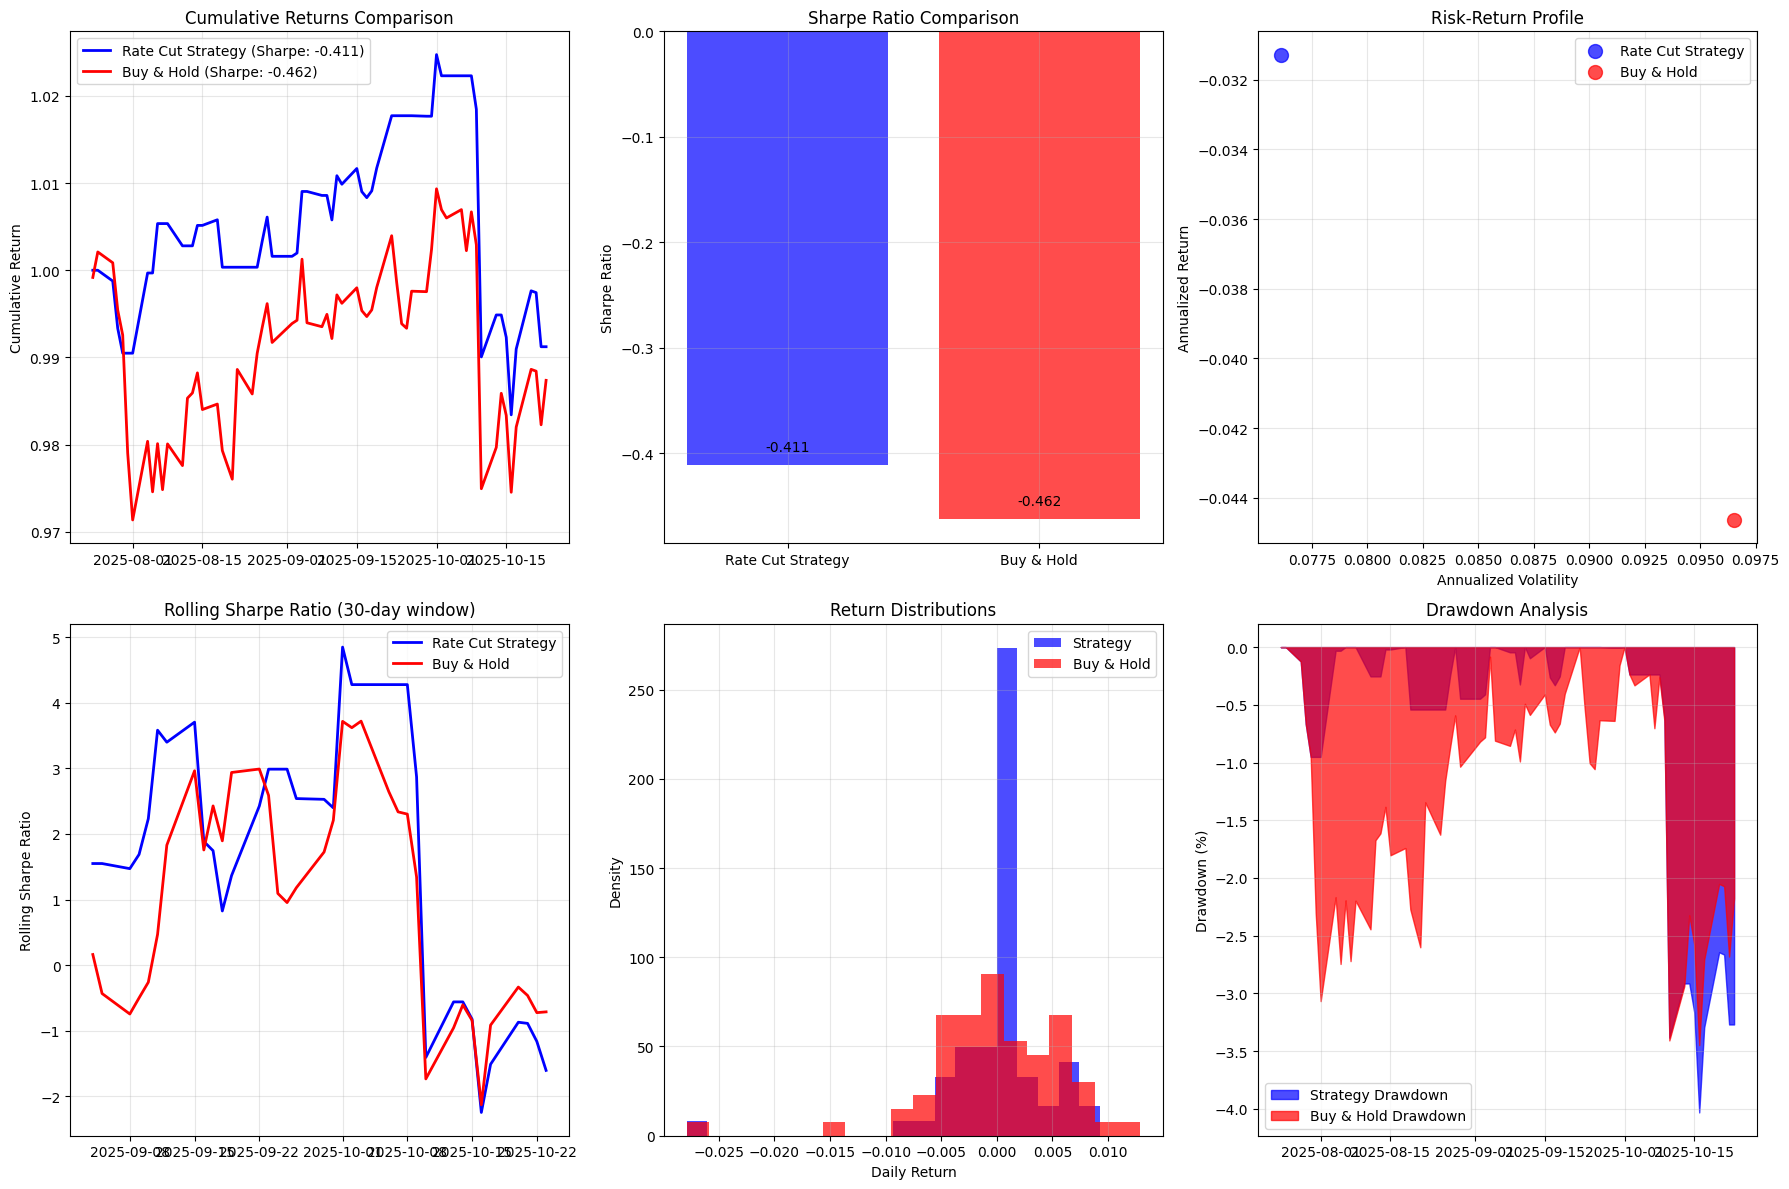


📊 Detailed Sharpe Ratio Analysis
Strategy Sharpe Components:
  Mean Daily Return: -0.000124
  Daily Volatility: 0.004794
  Annualized Return: -0.0313
  Annualized Volatility: 0.0761
  Sharpe Ratio: -0.4110

Buy & Hold Sharpe Components:
  Mean Daily Return: -0.000177
  Daily Volatility: 0.006081
  Annualized Return: -0.0446
  Annualized Volatility: 0.0965
  Sharpe Ratio: -0.4625

📈 Sharpe Ratio Interpretation:
✅ Strategy outperforms Buy & Hold on risk-adjusted basis
   Sharpe advantage: 0.0515

📊 Performance Summary Table:
Metric                    Strategy        Buy & Hold      Difference     
--------------------------------------------------------------------------------
Total Return              -0.0088         -0.0126         0.0039         
Annual Return             -0.0313         -0.0446         0.0134         
Annual Volatility         0.0761          0.0965          -0.0204        
Sharpe Ratio              -0.4110         -0.4625         0.0515         
Max Drawdown       

In [17]:
# Enhanced Rate Cut Strategy with Comprehensive Sharpe Ratio Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['font.size'] = 10

print("🚀 Enhanced Rate Cut Strategy with Sharpe Ratios")
print("=" * 60)

# Load the cleaned merged data
data_path = "../data/merged_sp500_polymarket_properly_cleaned.csv"
df = pd.read_csv(data_path, index_col=0, parse_dates=True)

print(f"📊 Loaded data: {df.shape} records")
print(f"📅 Date range: {df.index.min()} to {df.index.max()}")

# 🔧 STRATEGY SETUP
print("\n🔧 Setting up strategy...")

# Calculate rate cut probability change from previous day
df['Rate_Cut_Change'] = df['Rate_Cut_Probability'].diff()

# Create strategy signal: 1 if rate cut probability increased, 0 otherwise
df['Strategy_Signal'] = (df['Rate_Cut_Change'] > 0).astype(int)

# Calculate strategy returns: Buy at open, sell at close if signal = 1
df['Strategy_Return'] = np.where(
    df['Strategy_Signal'] == 1,
    (df['Close'] - df['Open']) / df['Open'],
    0
)

# Calculate buy-and-hold returns for comparison
df['Buy_Hold_Return'] = (df['Close'] - df['Open']) / df['Open']

# Calculate cumulative returns
df['Strategy_Cumulative'] = (1 + df['Strategy_Return']).cumprod()
df['Buy_Hold_Cumulative'] = (1 + df['Buy_Hold_Return']).cumprod()

print(f"📈 Strategy signals generated: {df['Strategy_Signal'].sum()} out of {len(df)} days")
print(f"📊 Signal frequency: {df['Strategy_Signal'].mean():.2%}")

# 📊 SHARPE RATIO CALCULATIONS
print("\n📊 Sharpe Ratio Analysis")
print("=" * 40)

# Risk-free rate (approximate with 0 for simplicity, or use actual rates)
risk_free_rate = 0.0  # You can update this with actual risk-free rate

# Calculate Sharpe ratios
def calculate_sharpe_ratio(returns, risk_free_rate=0.0, periods_per_year=252):
    """
    Calculate Sharpe ratio for a series of returns
    """
    excess_returns = returns - risk_free_rate / periods_per_year
    if returns.std() == 0:
        return np.nan
    return (excess_returns.mean() * periods_per_year) / (returns.std() * np.sqrt(periods_per_year))

# Strategy Sharpe ratios
strategy_sharpe = calculate_sharpe_ratio(df['Strategy_Return'])
buy_hold_sharpe = calculate_sharpe_ratio(df['Buy_Hold_Return'])

# Annualized metrics
strategy_annual_return = df['Strategy_Return'].mean() * 252
strategy_annual_vol = df['Strategy_Return'].std() * np.sqrt(252)
buy_hold_annual_return = df['Buy_Hold_Return'].mean() * 252
buy_hold_annual_vol = df['Buy_Hold_Return'].std() * np.sqrt(252)

print(f"Strategy Sharpe Ratio: {strategy_sharpe:.4f}")
print(f"  Annualized Return: {strategy_annual_return:.4f} ({strategy_annual_return*100:.2f}%)")
print(f"  Annualized Volatility: {strategy_annual_vol:.4f} ({strategy_annual_vol*100:.2f}%)")

print(f"\nBuy & Hold Sharpe Ratio: {buy_hold_sharpe:.4f}")
print(f"  Annualized Return: {buy_hold_annual_return:.4f} ({buy_hold_annual_return*100:.2f}%)")
print(f"  Annualized Volatility: {buy_hold_annual_vol:.4f} ({buy_hold_annual_vol*100:.2f}%)")

# Additional risk metrics
print(f"\n📊 Additional Risk Metrics:")
print(f"Strategy:")
print(f"  Max Drawdown: {(df['Strategy_Cumulative'] / df['Strategy_Cumulative'].cummax() - 1).min():.4f}")
print(f"  Calmar Ratio: {strategy_annual_return / abs((df['Strategy_Cumulative'] / df['Strategy_Cumulative'].cummax() - 1).min()):.4f}")
print(f"  Sortino Ratio: {strategy_annual_return / (df['Strategy_Return'][df['Strategy_Return'] < 0].std() * np.sqrt(252)):.4f}")

print(f"\nBuy & Hold:")
print(f"  Max Drawdown: {(df['Buy_Hold_Cumulative'] / df['Buy_Hold_Cumulative'].cummax() - 1).min():.4f}")
print(f"  Calmar Ratio: {buy_hold_annual_return / abs((df['Buy_Hold_Cumulative'] / df['Buy_Hold_Cumulative'].cummax() - 1).min()):.4f}")
print(f"  Sortino Ratio: {buy_hold_annual_return / (df['Buy_Hold_Return'][df['Buy_Hold_Return'] < 0].std() * np.sqrt(252)):.4f}")

# 📈 VISUALIZATION
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Cumulative returns comparison
ax1 = axes[0, 0]
ax1.plot(df.index, df['Strategy_Cumulative'], 'b-', linewidth=2, label=f'Rate Cut Strategy (Sharpe: {strategy_sharpe:.3f})')
ax1.plot(df.index, df['Buy_Hold_Cumulative'], 'r-', linewidth=2, label=f'Buy & Hold (Sharpe: {buy_hold_sharpe:.3f})')
ax1.set_title('Cumulative Returns Comparison')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Sharpe ratio comparison
ax2 = axes[0, 1]
strategies = ['Rate Cut Strategy', 'Buy & Hold']
sharpe_ratios = [strategy_sharpe, buy_hold_sharpe]
colors = ['blue', 'red']
bars = ax2.bar(strategies, sharpe_ratios, color=colors, alpha=0.7)
ax2.set_title('Sharpe Ratio Comparison')
ax2.set_ylabel('Sharpe Ratio')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, ratio in zip(bars, sharpe_ratios):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{ratio:.3f}', ha='center', va='bottom')

# Plot 3: Risk-Return scatter
ax3 = axes[0, 2]
ax3.scatter(strategy_annual_vol, strategy_annual_return, s=100, c='blue', alpha=0.7, label='Rate Cut Strategy')
ax3.scatter(buy_hold_annual_vol, buy_hold_annual_return, s=100, c='red', alpha=0.7, label='Buy & Hold')
ax3.set_xlabel('Annualized Volatility')
ax3.set_ylabel('Annualized Return')
ax3.set_title('Risk-Return Profile')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Rolling Sharpe ratios (30-day window)
ax4 = axes[1, 0]
rolling_window = 30
df['Strategy_Rolling_Sharpe'] = df['Strategy_Return'].rolling(rolling_window).apply(
    lambda x: calculate_sharpe_ratio(x) if len(x) == rolling_window else np.nan
)
df['Buy_Hold_Rolling_Sharpe'] = df['Buy_Hold_Return'].rolling(rolling_window).apply(
    lambda x: calculate_sharpe_ratio(x) if len(x) == rolling_window else np.nan
)

ax4.plot(df.index, df['Strategy_Rolling_Sharpe'], 'b-', linewidth=2, label='Rate Cut Strategy')
ax4.plot(df.index, df['Buy_Hold_Rolling_Sharpe'], 'r-', linewidth=2, label='Buy & Hold')
ax4.set_title(f'Rolling Sharpe Ratio ({rolling_window}-day window)')
ax4.set_ylabel('Rolling Sharpe Ratio')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Return distributions
ax5 = axes[1, 1]
ax5.hist(df['Strategy_Return'], bins=20, alpha=0.7, color='blue', label='Strategy', density=True)
ax5.hist(df['Buy_Hold_Return'], bins=20, alpha=0.7, color='red', label='Buy & Hold', density=True)
ax5.set_title('Return Distributions')
ax5.set_xlabel('Daily Return')
ax5.set_ylabel('Density')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Drawdown analysis
ax6 = axes[1, 2]
strategy_drawdown = (df['Strategy_Cumulative'] / df['Strategy_Cumulative'].cummax() - 1) * 100
buy_hold_drawdown = (df['Buy_Hold_Cumulative'] / df['Buy_Hold_Cumulative'].cummax() - 1) * 100

ax6.fill_between(df.index, strategy_drawdown, 0, alpha=0.7, color='blue', label='Strategy Drawdown')
ax6.fill_between(df.index, buy_hold_drawdown, 0, alpha=0.7, color='red', label='Buy & Hold Drawdown')
ax6.set_title('Drawdown Analysis')
ax6.set_ylabel('Drawdown (%)')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 📊 DETAILED SHARPE ANALYSIS
print("\n📊 Detailed Sharpe Ratio Analysis")
print("=" * 50)

# Sharpe ratio components
print(f"Strategy Sharpe Components:")
print(f"  Mean Daily Return: {df['Strategy_Return'].mean():.6f}")
print(f"  Daily Volatility: {df['Strategy_Return'].std():.6f}")
print(f"  Annualized Return: {strategy_annual_return:.4f}")
print(f"  Annualized Volatility: {strategy_annual_vol:.4f}")
print(f"  Sharpe Ratio: {strategy_sharpe:.4f}")

print(f"\nBuy & Hold Sharpe Components:")
print(f"  Mean Daily Return: {df['Buy_Hold_Return'].mean():.6f}")
print(f"  Daily Volatility: {df['Buy_Hold_Return'].std():.6f}")
print(f"  Annualized Return: {buy_hold_annual_return:.4f}")
print(f"  Annualized Volatility: {buy_hold_annual_vol:.4f}")
print(f"  Sharpe Ratio: {buy_hold_sharpe:.4f}")

# Sharpe ratio interpretation
print(f"\n📈 Sharpe Ratio Interpretation:")
if strategy_sharpe > buy_hold_sharpe:
    print(f"✅ Strategy outperforms Buy & Hold on risk-adjusted basis")
    print(f"   Sharpe advantage: {strategy_sharpe - buy_hold_sharpe:.4f}")
else:
    print(f"❌ Buy & Hold outperforms Strategy on risk-adjusted basis")
    print(f"   Sharpe disadvantage: {buy_hold_sharpe - strategy_sharpe:.4f}")

# Performance summary table
print(f"\n📊 Performance Summary Table:")
print("=" * 80)
print(f"{'Metric':<25} {'Strategy':<15} {'Buy & Hold':<15} {'Difference':<15}")
print("-" * 80)
print(f"{'Total Return':<25} {df['Strategy_Cumulative'].iloc[-1]-1:<15.4f} {df['Buy_Hold_Cumulative'].iloc[-1]-1:<15.4f} {df['Strategy_Cumulative'].iloc[-1]-df['Buy_Hold_Cumulative'].iloc[-1]:<15.4f}")
print(f"{'Annual Return':<25} {strategy_annual_return:<15.4f} {buy_hold_annual_return:<15.4f} {strategy_annual_return-buy_hold_annual_return:<15.4f}")
print(f"{'Annual Volatility':<25} {strategy_annual_vol:<15.4f} {buy_hold_annual_vol:<15.4f} {strategy_annual_vol-buy_hold_annual_vol:<15.4f}")
print(f"{'Sharpe Ratio':<25} {strategy_sharpe:<15.4f} {buy_hold_sharpe:<15.4f} {strategy_sharpe-buy_hold_sharpe:<15.4f}")
print(f"{'Max Drawdown':<25} {strategy_drawdown.min():<15.4f} {buy_hold_drawdown.min():<15.4f} {strategy_drawdown.min()-buy_hold_drawdown.min():<15.4f}")

# Save results
results_path = "../data/rate_cut_strategy_sharpe_analysis.csv"
df.to_csv(results_path)
print(f"\n💾 Saved enhanced strategy results to: {results_path}")

print("\n✅ Enhanced strategy analysis with Sharpe ratios complete!")

🔄 Inverse Rate Cut Strategy Analysis (FIXED)
📊 Loaded data: (65, 22) records
📅 Date range: 2025-07-24 00:00:00 to 2025-10-23 00:00:00

🔧 Setting up INVERSE strategy...
📈 Inverse strategy signals: 36 out of 65 days
📊 Signal frequency: 55.38%

📊 Sharpe Ratio Analysis - All Strategies
🔄 INVERSE Strategy:
  Sharpe Ratio: 0.4110
  Annualized Return: 0.0313 (3.13%)
  Annualized Volatility: 0.0761 (7.61%)

📈 ORIGINAL Strategy:
  Sharpe Ratio: -0.4110
  Annualized Return: -0.0313 (-3.13%)
  Annualized Volatility: 0.0761 (7.61%)

📊 BUY & HOLD:
  Sharpe Ratio: -0.4625
  Annualized Return: -0.0446 (-4.46%)
  Annualized Volatility: 0.0965 (9.65%)


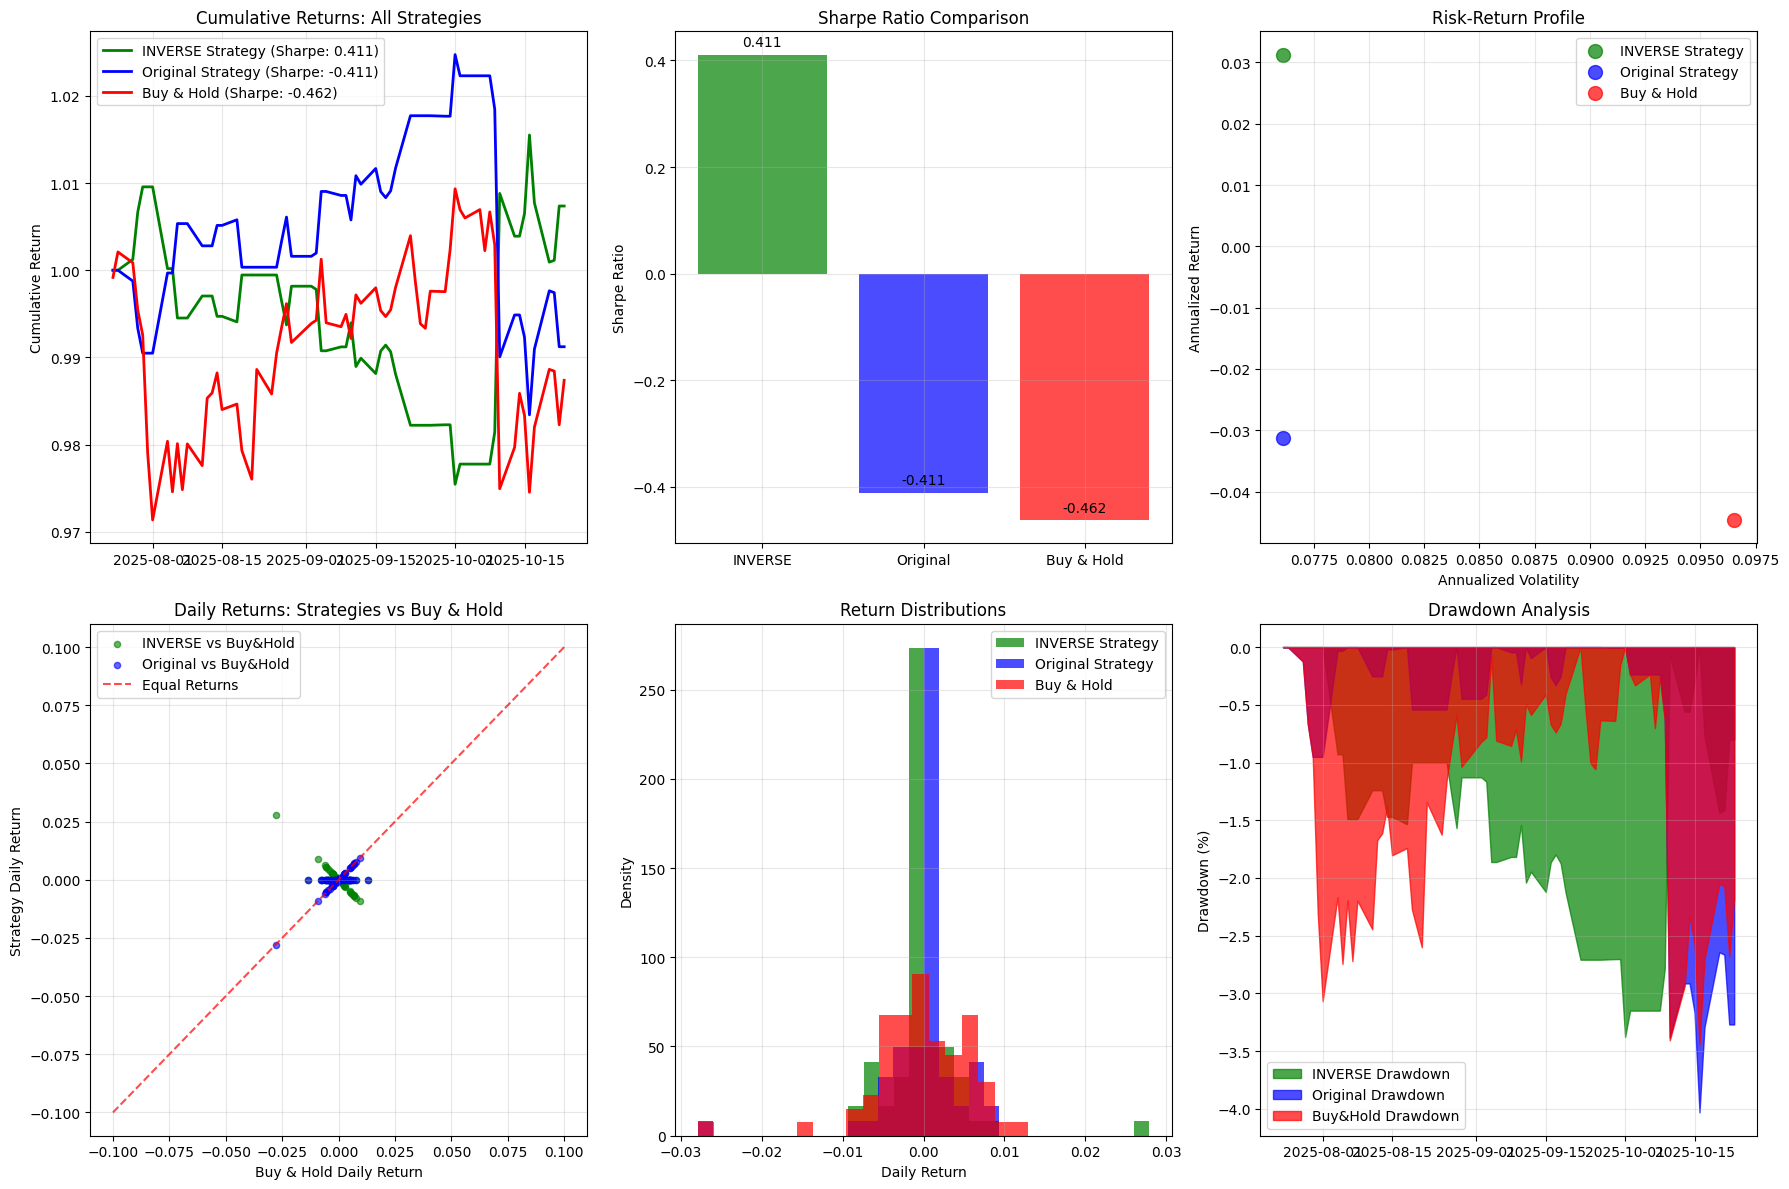


📊 Strategy Comparison Analysis

📊 Performance Summary Table:
Metric                    INVERSE         Original        Buy & Hold      Best           
------------------------------------------------------------------------------------------
Total Return              0.0074          -0.0088         -0.0126         INVERSE        
Annual Return             0.0313          -0.0313         -0.0446         INVERSE        
Sharpe Ratio              0.4110          -0.4110         -0.4625         INVERSE        
Max Drawdown              -3.3785         -4.0316         -3.4479         INVERSE        

🎯 Strategy Interpretation:
✅ INVERSE strategy is the best performer!
   → Market tends to move OPPOSITE to rate cut expectations
   → When rate cuts are expected, market often falls

💾 Saved inverse strategy results to: ../data/inverse_rate_cut_strategy_analysis.csv

✅ Inverse strategy analysis complete!


In [19]:
# Inverse Rate Cut Strategy: Sell when Rate Cut Probability Increases (FIXED)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['font.size'] = 10

print("🔄 Inverse Rate Cut Strategy Analysis (FIXED)")
print("=" * 60)

# Load the cleaned merged data
data_path = "../data/merged_sp500_polymarket_properly_cleaned.csv"
df = pd.read_csv(data_path, index_col=0, parse_dates=True)

print(f"📊 Loaded data: {df.shape} records")
print(f"📅 Date range: {df.index.min()} to {df.index.max()}")

# 🔧 INVERSE STRATEGY SETUP
print("\n🔧 Setting up INVERSE strategy...")

# Calculate rate cut probability change from previous day
df['Rate_Cut_Change'] = df['Rate_Cut_Probability'].diff()

# INVERSE SIGNAL: Sell when rate cut probability increases (contrarian)
df['Inverse_Signal'] = (df['Rate_Cut_Change'] > 0).astype(int)

# INVERSE STRATEGY: Short when rate cut probability increases
# Return = (Open - Close) / Open if signal = 1, else 0
df['Inverse_Strategy_Return'] = np.where(
    df['Inverse_Signal'] == 1,
    (df['Open'] - df['Close']) / df['Open'],  # Short position: profit when price goes down
    0
)

# Keep original strategy for comparison
df['Original_Strategy_Return'] = np.where(
    df['Inverse_Signal'] == 1,
    (df['Close'] - df['Open']) / df['Open'],  # Long position
    0
)

# Calculate buy-and-hold returns for comparison
df['Buy_Hold_Return'] = (df['Close'] - df['Open']) / df['Open']

# Calculate cumulative returns
df['Inverse_Strategy_Cumulative'] = (1 + df['Inverse_Strategy_Return']).cumprod()
df['Original_Strategy_Cumulative'] = (1 + df['Original_Strategy_Return']).cumprod()  # FIXED: Capital O
df['Buy_Hold_Cumulative'] = (1 + df['Buy_Hold_Return']).cumprod()

print(f"📈 Inverse strategy signals: {df['Inverse_Signal'].sum()} out of {len(df)} days")
print(f"📊 Signal frequency: {df['Inverse_Signal'].mean():.2%}")

# 📊 SHARPE RATIO CALCULATIONS
print("\n📊 Sharpe Ratio Analysis - All Strategies")
print("=" * 50)

def calculate_sharpe_ratio(returns, risk_free_rate=0.0, periods_per_year=252):
    excess_returns = returns - risk_free_rate / periods_per_year
    if returns.std() == 0:
        return np.nan
    return (excess_returns.mean() * periods_per_year) / (returns.std() * np.sqrt(periods_per_year))

# Calculate Sharpe ratios for all strategies
inverse_sharpe = calculate_sharpe_ratio(df['Inverse_Strategy_Return'])
original_sharpe = calculate_sharpe_ratio(df['Original_Strategy_Return'])
buy_hold_sharpe = calculate_sharpe_ratio(df['Buy_Hold_Return'])

# Annualized metrics
inverse_annual_return = df['Inverse_Strategy_Return'].mean() * 252
inverse_annual_vol = df['Inverse_Strategy_Return'].std() * np.sqrt(252)
original_annual_return = df['Original_Strategy_Return'].mean() * 252
original_annual_vol = df['Original_Strategy_Return'].std() * np.sqrt(252)
buy_hold_annual_return = df['Buy_Hold_Return'].mean() * 252
buy_hold_annual_vol = df['Buy_Hold_Return'].std() * np.sqrt(252)

print(f"🔄 INVERSE Strategy:")
print(f"  Sharpe Ratio: {inverse_sharpe:.4f}")
print(f"  Annualized Return: {inverse_annual_return:.4f} ({inverse_annual_return*100:.2f}%)")
print(f"  Annualized Volatility: {inverse_annual_vol:.4f} ({inverse_annual_vol*100:.2f}%)")

print(f"\n📈 ORIGINAL Strategy:")
print(f"  Sharpe Ratio: {original_sharpe:.4f}")
print(f"  Annualized Return: {original_annual_return:.4f} ({original_annual_return*100:.2f}%)")
print(f"  Annualized Volatility: {original_annual_vol:.4f} ({original_annual_vol*100:.2f}%)")

print(f"\n📊 BUY & HOLD:")
print(f"  Sharpe Ratio: {buy_hold_sharpe:.4f}")
print(f"  Annualized Return: {buy_hold_annual_return:.4f} ({buy_hold_annual_return*100:.2f}%)")
print(f"  Annualized Volatility: {buy_hold_annual_vol:.4f} ({buy_hold_annual_vol*100:.2f}%)")

# 📈 VISUALIZATION
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Cumulative returns comparison
ax1 = axes[0, 0]
ax1.plot(df.index, df['Inverse_Strategy_Cumulative'], 'g-', linewidth=2, label=f'INVERSE Strategy (Sharpe: {inverse_sharpe:.3f})')
ax1.plot(df.index, df['Original_Strategy_Cumulative'], 'b-', linewidth=2, label=f'Original Strategy (Sharpe: {original_sharpe:.3f})')  # FIXED
ax1.plot(df.index, df['Buy_Hold_Cumulative'], 'r-', linewidth=2, label=f'Buy & Hold (Sharpe: {buy_hold_sharpe:.3f})')
ax1.set_title('Cumulative Returns: All Strategies')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Sharpe ratio comparison
ax2 = axes[0, 1]
strategies = ['INVERSE', 'Original', 'Buy & Hold']
sharpe_ratios = [inverse_sharpe, original_sharpe, buy_hold_sharpe]
colors = ['green', 'blue', 'red']
bars = ax2.bar(strategies, sharpe_ratios, color=colors, alpha=0.7)
ax2.set_title('Sharpe Ratio Comparison')
ax2.set_ylabel('Sharpe Ratio')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, ratio in zip(bars, sharpe_ratios):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{ratio:.3f}', ha='center', va='bottom')

# Plot 3: Risk-Return scatter
ax3 = axes[0, 2]
ax3.scatter(inverse_annual_vol, inverse_annual_return, s=100, c='green', alpha=0.7, label='INVERSE Strategy')
ax3.scatter(original_annual_vol, original_annual_return, s=100, c='blue', alpha=0.7, label='Original Strategy')
ax3.scatter(buy_hold_annual_vol, buy_hold_annual_return, s=100, c='red', alpha=0.7, label='Buy & Hold')
ax3.set_xlabel('Annualized Volatility')
ax3.set_ylabel('Annualized Return')
ax3.set_title('Risk-Return Profile')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Daily returns comparison
ax4 = axes[1, 0]
ax4.scatter(df['Buy_Hold_Return'], df['Inverse_Strategy_Return'], alpha=0.6, s=20, c='green', label='INVERSE vs Buy&Hold')
ax4.scatter(df['Buy_Hold_Return'], df['Original_Strategy_Return'], alpha=0.6, s=20, c='blue', label='Original vs Buy&Hold')
ax4.plot([-0.1, 0.1], [-0.1, 0.1], 'r--', alpha=0.7, label='Equal Returns')
ax4.set_xlabel('Buy & Hold Daily Return')
ax4.set_ylabel('Strategy Daily Return')
ax4.set_title('Daily Returns: Strategies vs Buy & Hold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Return distributions
ax5 = axes[1, 1]
ax5.hist(df['Inverse_Strategy_Return'], bins=20, alpha=0.7, color='green', label='INVERSE Strategy', density=True)
ax5.hist(df['Original_Strategy_Return'], bins=20, alpha=0.7, color='blue', label='Original Strategy', density=True)
ax5.hist(df['Buy_Hold_Return'], bins=20, alpha=0.7, color='red', label='Buy & Hold', density=True)
ax5.set_title('Return Distributions')
ax5.set_xlabel('Daily Return')
ax5.set_ylabel('Density')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Drawdown analysis
ax6 = axes[1, 2]
inverse_drawdown = (df['Inverse_Strategy_Cumulative'] / df['Inverse_Strategy_Cumulative'].cummax() - 1) * 100
original_drawdown = (df['Original_Strategy_Cumulative'] / df['Original_Strategy_Cumulative'].cummax() - 1) * 100  # FIXED
buy_hold_drawdown = (df['Buy_Hold_Cumulative'] / df['Buy_Hold_Cumulative'].cummax() - 1) * 100

ax6.fill_between(df.index, inverse_drawdown, 0, alpha=0.7, color='green', label='INVERSE Drawdown')
ax6.fill_between(df.index, original_drawdown, 0, alpha=0.7, color='blue', label='Original Drawdown')
ax6.fill_between(df.index, buy_hold_drawdown, 0, alpha=0.7, color='red', label='Buy&Hold Drawdown')
ax6.set_title('Drawdown Analysis')
ax6.set_ylabel('Drawdown (%)')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 📊 DETAILED COMPARISON
print("\n📊 Strategy Comparison Analysis")
print("=" * 60)

# Performance summary table
print(f"\n📊 Performance Summary Table:")
print("=" * 90)
print(f"{'Metric':<25} {'INVERSE':<15} {'Original':<15} {'Buy & Hold':<15} {'Best':<15}")
print("-" * 90)

# Total returns
inverse_total = df['Inverse_Strategy_Cumulative'].iloc[-1] - 1
original_total = df['Original_Strategy_Cumulative'].iloc[-1] - 1  # FIXED
buy_hold_total = df['Buy_Hold_Cumulative'].iloc[-1] - 1

best_total = max(inverse_total, original_total, buy_hold_total)
best_total_name = ['INVERSE', 'Original', 'Buy&Hold'][np.argmax([inverse_total, original_total, buy_hold_total])]

print(f"{'Total Return':<25} {inverse_total:<15.4f} {original_total:<15.4f} {buy_hold_total:<15.4f} {best_total_name:<15}")

# Annual returns
best_annual = max(inverse_annual_return, original_annual_return, buy_hold_annual_return)
best_annual_name = ['INVERSE', 'Original', 'Buy&Hold'][np.argmax([inverse_annual_return, original_annual_return, buy_hold_annual_return])]

print(f"{'Annual Return':<25} {inverse_annual_return:<15.4f} {original_annual_return:<15.4f} {buy_hold_annual_return:<15.4f} {best_annual_name:<15}")

# Sharpe ratios
best_sharpe = max(inverse_sharpe, original_sharpe, buy_hold_sharpe)
best_sharpe_name = ['INVERSE', 'Original', 'Buy&Hold'][np.argmax([inverse_sharpe, original_sharpe, buy_hold_sharpe])]

print(f"{'Sharpe Ratio':<25} {inverse_sharpe:<15.4f} {original_sharpe:<15.4f} {buy_hold_sharpe:<15.4f} {best_sharpe_name:<15}")

# Max drawdowns
inverse_max_dd = inverse_drawdown.min()
original_max_dd = original_drawdown.min()
buy_hold_max_dd = buy_hold_drawdown.min()

best_dd = max(inverse_max_dd, original_max_dd, buy_hold_max_dd)  # Less negative is better
best_dd_name = ['INVERSE', 'Original', 'Buy&Hold'][np.argmax([inverse_max_dd, original_max_dd, buy_hold_max_dd])]

print(f"{'Max Drawdown':<25} {inverse_max_dd:<15.4f} {original_max_dd:<15.4f} {buy_hold_max_dd:<15.4f} {best_dd_name:<15}")

# Strategy interpretation
print(f"\n🎯 Strategy Interpretation:")
if inverse_sharpe > original_sharpe and inverse_sharpe > buy_hold_sharpe:
    print("✅ INVERSE strategy is the best performer!")
    print("   → Market tends to move OPPOSITE to rate cut expectations")
    print("   → When rate cuts are expected, market often falls")
elif original_sharpe > inverse_sharpe and original_sharpe > buy_hold_sharpe:
    print("✅ ORIGINAL strategy is the best performer!")
    print("   → Market tends to move WITH rate cut expectations")
    print("   → When rate cuts are expected, market often rises")
else:
    print("✅ BUY & HOLD is the best performer!")
    print("   → Neither strategy beats simple buy and hold")
    print("   → Rate cut expectations may not be predictive")

# Save results
results_path = "../data/inverse_rate_cut_strategy_analysis.csv"
df.to_csv(results_path)
print(f"\n💾 Saved inverse strategy results to: {results_path}")

print("\n✅ Inverse strategy analysis complete!")